In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist

pyro.clear_param_store()

class GP:
    def __init__(self, noise_variance=0.01):
        # Initialize with the values that gave us good results
        self.kernel_variance = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.kernel_lengthscale = torch.nn.Parameter(torch.tensor(0.065, requires_grad=True))  # Initialize close to the good value we found
        self.noise_variance = torch.tensor(noise_variance)

    def kernel(self, x1: torch.Tensor, x2: torch.Tensor = None) -> torch.Tensor:
        if x2 is None:
            x2 = x1
        x1, x2 = x1.reshape(-1, 1), x2.reshape(-1, 1)
        dist_matrix = (x1 - x2.T)**2
        return self.kernel_variance * torch.exp(-0.5 * dist_matrix / self.kernel_lengthscale**2)

    def fit_map(self, x_train, y_train, num_steps=1000, learning_rate=0.01):
        optimizer = torch.optim.Adam([self.kernel_variance, self.kernel_lengthscale], lr=learning_rate)
        losses = []
        
        # Use the original priors that worked well
        prior_variance = dist.LogNormal(-0.64, 0.5)  # Original prior
        prior_lengthscale = dist.LogNormal(-2.94, 0.5)  # Original prior
        
        for step in range(num_steps):
            optimizer.zero_grad()
            
            K = self.kernel(x_train) + self.noise_variance * torch.eye(len(x_train))
            L = torch.linalg.cholesky(K)
            alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
            
            nll = 0.5 * (y_train.T @ alpha + torch.logdet(K) + len(x_train) * torch.log(torch.tensor(2 * np.pi)))
            prior_term = -prior_variance.log_prob(self.kernel_variance) - prior_lengthscale.log_prob(self.kernel_lengthscale)
            
            loss = nll + prior_term.sum()
            losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            if (step + 1) % 200 == 0:
                print(f"Step {step+1}, Loss: {loss.item():.3f}")
                print(f"  Kernel Variance: {self.kernel_variance.item():.3f}")
                print(f"  Kernel Lengthscale: {self.kernel_lengthscale.item():.3f}")
    
        return losses

    def predict(self, x_train, y_train, x_test):
        K = self.kernel(x_train) + self.noise_variance * torch.eye(len(x_train))
        K_star = self.kernel(x_train, x_test)
        K_star_star = self.kernel(x_test)

        L = torch.linalg.cholesky(K)
        alpha = torch.linalg.solve(L.T, torch.linalg.solve(L, y_train))
        mean = K_star.T @ alpha
        
        v = torch.linalg.solve(L, K_star)
        var = K_star_star - v.T @ v
        var = var.diagonal()

        return mean, var


In [2]:
# Helper Functions
def generate_data(n_points=30):
    x = torch.linspace(0, 1, n_points)
    y_true = -(torch.sin(6 * np.pi * x))**2 + 6 * x**2 - 5 * x**4 + 3/2
    y = y_true + torch.normal(0, np.sqrt(0.01), size=y_true.shape)
    return x, y

def plot_gp_fit(gp, x_train, y_train, x_test, y_test):
    x_pred = torch.linspace(0, 1, 200)
    mean, var = gp.predict(x_train, y_train, x_pred)
    std = torch.sqrt(var)

    plt.figure(figsize=(12, 6))

    # Plot true function
    x_true = torch.linspace(0, 1, 1000)
    y_true = -(torch.sin(6 * np.pi * x_true))**2 + 6 * x_true**2 - 5 * x_true**4 + 3/2
    plt.plot(x_true, y_true, 'g--', alpha=0.5, label='True Function')

    # Plot data points
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.scatter(x_test, y_test, c='red', label='Test Data')

    # Plot GP prediction
    plt.plot(x_pred, mean.detach(), 'k-', label='Posterior Mean')
    plt.fill_between(
        x_pred.numpy(),
        (mean - 2 * std).detach().numpy(),
        (mean + 2 * std).detach().numpy(),
        color='gray',
        alpha=0.2,
        label='95% Confidence'
    )
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Regression Results with MAP')
    plt.legend()
    plt.grid(True)
    plt.show()

def compute_map_test_likelihood(gp, x_train, y_train, x_test, y_test):
    """
    Computes the test likelihood for MAP estimation
    
    Args:
        gp: Fitted GP model with MAP parameters
        x_train: Training inputs
        y_train: Training targets
        x_test: Test inputs
        y_test: Test targets
        
    Returns:
        test_ll: Test log likelihood
        theta: Dictionary of hyperparameters
    """
    mean, var = gp.predict(x_train, y_train, x_test)
    std = torch.sqrt(var)
    test_ll = torch.distributions.Normal(mean, std).log_prob(y_test).sum().item()
    
    # Store the hyperparameters used
    theta = {
        'kernel_variance': gp.kernel_variance.item(),
        'kernel_lengthscale': gp.kernel_lengthscale.item()
    }
    
    return test_ll, theta

Fitting GP with MAP...
Step 200, Loss: 22.173
  Kernel Variance: 1.617
  Kernel Lengthscale: 0.070
Step 400, Loss: 22.173
  Kernel Variance: 1.621
  Kernel Lengthscale: 0.070
Step 600, Loss: 22.173
  Kernel Variance: 1.621
  Kernel Lengthscale: 0.070
Step 800, Loss: 22.173
  Kernel Variance: 1.621
  Kernel Lengthscale: 0.070
Step 1000, Loss: 22.173
  Kernel Variance: 1.621
  Kernel Lengthscale: 0.070
Final MAP Loss: 22.173


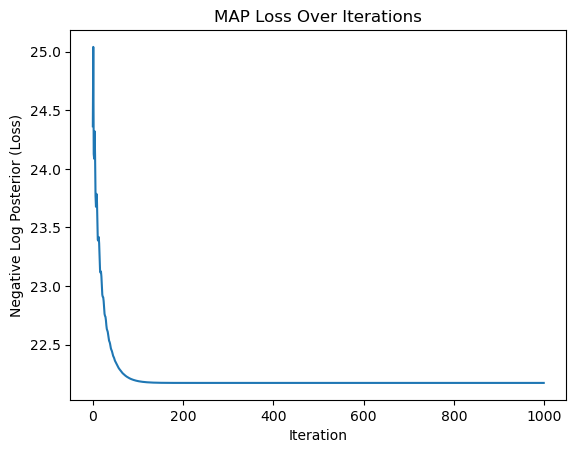

MAP Test Log Likelihood: -1.216


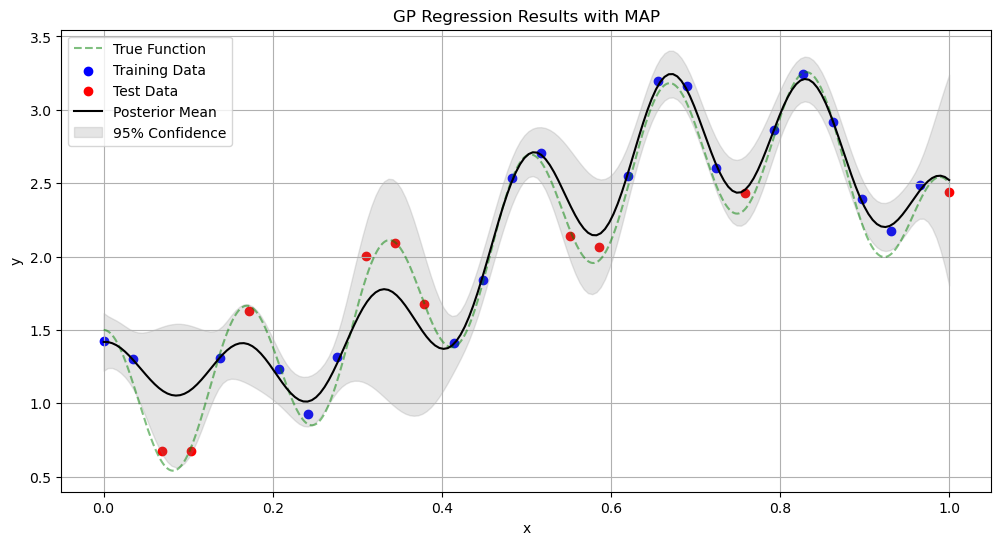

In [8]:
# Generate one dataset
x, y = generate_data(n_points=30)
indices = torch.randperm(len(x))
train_indices = indices[:20]
test_indices = indices[20:]

x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

# Initialize the GP model
gp = GP()

# Fit GP using MAP estimation
print("Fitting GP with MAP...")
map_losses = gp.fit_map(x_train, y_train, num_steps=1000, learning_rate=0.01)
print(f"Final MAP Loss: {map_losses[-1]:.3f}")

# Plot the MAP loss curve
plt.plot(map_losses)
plt.title("MAP Loss Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Negative Log Posterior (Loss)")
plt.show()

# Evaluate GP (MAP) on test set
mean, var = gp.predict(x_train, y_train, x_test)
std = torch.sqrt(var)
log_likelihood = torch.distributions.Normal(mean, std).log_prob(y_test).sum()
print(f"MAP Test Log Likelihood: {log_likelihood.item():.3f}")

# Plot GP fit for MAP
plot_gp_fit(gp, x_train, y_train, x_test, y_test)

In [58]:
# After fitting GP with MAP
test_ll, theta = compute_map_test_likelihood(gp, x_train, y_train, x_test, y_test)
print(f"Test Log Likelihood: {test_ll:.3f}")
print("MAP parameters (θ):", theta)

Test Log Likelihood: -1.415
MAP parameters (θ): {'kernel_variance': 1.566440224647522, 'kernel_lengthscale': 0.06439872831106186}


In [59]:
# Initialize and fit
gp = GP()
losses = gp.fit_map(x_train, y_train)

# Predict
mean, var = gp.predict(x_train, y_train, x_test)

Step 200, Loss: 26.963
  Kernel Variance: 1.566
  Kernel Lengthscale: 0.064
Step 400, Loss: 26.963
  Kernel Variance: 1.566
  Kernel Lengthscale: 0.064
Step 600, Loss: 26.963
  Kernel Variance: 1.566
  Kernel Lengthscale: 0.064
Step 800, Loss: 26.963
  Kernel Variance: 1.566
  Kernel Lengthscale: 0.064
Step 1000, Loss: 26.963
  Kernel Variance: 1.566
  Kernel Lengthscale: 0.064


In [60]:
def run_map_trials(n_trials=20, num_steps=1000, learning_rate=0.01):
    """
    Run MAP estimation on multiple randomly generated datasets
    
    Args:
        n_trials: Number of different datasets to generate and test
        num_steps: Number of optimization steps for MAP
        learning_rate: Learning rate for optimization
    
    Returns:
        test_lls: List of test log likelihoods
        all_params: List of dictionaries containing hyperparameters for each trial
    """
    test_lls = []
    all_params = []
    
    for trial in range(n_trials):
        # Generate new dataset
        x, y = generate_data(n_points=30)
        indices = torch.randperm(len(x))
        train_indices = indices[:20]
        test_indices = indices[20:]
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        
        # Initialize and fit GP
        gp = GP()
        losses = gp.fit_map(x_train, y_train, num_steps=num_steps, learning_rate=learning_rate)
        
        # Compute test likelihood and store parameters
        mean, var = gp.predict(x_train, y_train, x_test)
        std = torch.sqrt(var)
        test_ll = torch.distributions.Normal(mean, std).log_prob(y_test).sum().item()
        
        params = {
            'kernel_variance': gp.kernel_variance.item(),
            'kernel_lengthscale': gp.kernel_lengthscale.item(),
            'final_loss': losses[-1]
        }
        
        test_lls.append(test_ll)
        all_params.append(params)
        
        print(f"Trial {trial+1}/20 - Test LL: {test_ll:.3f}, Params:", params)
    
    # Compute summary statistics
    test_lls = np.array(test_lls)
    print("\nResults Summary:")
    print(f"Test Log Likelihood: {np.mean(test_lls):.3f} ± {np.std(test_lls):.3f}")
    
    # Compute mean and std of hyperparameters
    variance_values = [p['kernel_variance'] for p in all_params]
    lengthscale_values = [p['kernel_lengthscale'] for p in all_params]
    
    print(f"Kernel Variance: {np.mean(variance_values):.3f} ± {np.std(variance_values):.3f}")
    print(f"Kernel Lengthscale: {np.mean(lengthscale_values):.3f} ± {np.std(lengthscale_values):.3f}")
    
    return test_lls, all_params

In [61]:
# Run x trials
test_lls, all_params = run_map_trials(n_trials=20)

Step 200, Loss: 26.080
  Kernel Variance: 1.672
  Kernel Lengthscale: 0.069
Step 400, Loss: 26.079
  Kernel Variance: 1.685
  Kernel Lengthscale: 0.069
Step 600, Loss: 26.079
  Kernel Variance: 1.685
  Kernel Lengthscale: 0.069
Step 800, Loss: 26.079
  Kernel Variance: 1.685
  Kernel Lengthscale: 0.069
Step 1000, Loss: 26.079
  Kernel Variance: 1.685
  Kernel Lengthscale: 0.069
Trial 1/20 - Test LL: 5.610, Params: {'kernel_variance': 1.6848828792572021, 'kernel_lengthscale': 0.06919015944004059, 'final_loss': 26.078998565673828}
Step 200, Loss: 24.502
  Kernel Variance: 1.542
  Kernel Lengthscale: 0.067
Step 400, Loss: 24.502
  Kernel Variance: 1.543
  Kernel Lengthscale: 0.067
Step 600, Loss: 24.502
  Kernel Variance: 1.543
  Kernel Lengthscale: 0.067
Step 800, Loss: 24.502
  Kernel Variance: 1.543
  Kernel Lengthscale: 0.067
Step 1000, Loss: 24.502
  Kernel Variance: 1.543
  Kernel Lengthscale: 0.067
Trial 2/20 - Test LL: 1.498, Params: {'kernel_variance': 1.542548418045044, 'kernel_

In [62]:
def run_map_trials_with_vis(n_trials=20, num_steps=1000, learning_rate=0.01):
    """Run MAP trials and return data for visualization"""
    test_lls = []
    kernel_variances = []
    kernel_lengthscales = []
    
    for trial in range(n_trials):
        # Generate new dataset
        x, y = generate_data(n_points=30)
        indices = torch.randperm(len(x))
        train_indices = indices[:20]
        test_indices = indices[20:]
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        
        # Initialize and fit GP
        gp = GP()
        losses = gp.fit_map(x_train, y_train, num_steps=num_steps, learning_rate=learning_rate)
        
        # Compute test likelihood and store parameters
        test_ll, theta = compute_map_test_likelihood(gp, x_train, y_train, x_test, y_test)
        
        test_lls.append(test_ll)
        kernel_variances.append(theta['kernel_variance'])
        kernel_lengthscales.append(theta['kernel_lengthscale'])
        
        print(f"Trial {trial+1}/20 - Test LL: {test_ll:.3f}, Variance: {theta['kernel_variance']:.3f}, Lengthscale: {theta['kernel_lengthscale']:.3f}")
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Test Log Likelihoods
    plt.subplot(131)
    plt.plot(range(1, n_trials+1), test_lls, 'bo-')
    plt.axhline(y=np.mean(test_lls), color='r', linestyle='--', label=f'Mean: {np.mean(test_lls):.3f}')
    plt.fill_between(range(1, n_trials+1), 
                    np.mean(test_lls) - np.std(test_lls), 
                    np.mean(test_lls) + np.std(test_lls),
                    alpha=0.2, color='r', label=f'Std: {np.std(test_lls):.3f}')
    plt.xlabel('Trial')
    plt.ylabel('Test Log Likelihood')
    plt.title('Test Log Likelihoods across Trials')
    plt.legend()
    
    # Plot 2: Kernel Variances
    plt.subplot(132)
    plt.plot(range(1, n_trials+1), kernel_variances, 'go-')
    plt.axhline(y=np.mean(kernel_variances), color='r', linestyle='--', label=f'Mean: {np.mean(kernel_variances):.3f}')
    plt.fill_between(range(1, n_trials+1), 
                    np.mean(kernel_variances) - np.std(kernel_variances),
                    np.mean(kernel_variances) + np.std(kernel_variances),
                    alpha=0.2, color='r', label=f'Std: {np.std(kernel_variances):.3f}')
    plt.xlabel('Trial')
    plt.ylabel('Kernel Variance')
    plt.title('Kernel Variances across Trials')
    plt.legend()
    
    # Plot 3: Kernel Lengthscales
    plt.subplot(133)
    plt.plot(range(1, n_trials+1), kernel_lengthscales, 'mo-')
    plt.axhline(y=np.mean(kernel_lengthscales), color='r', linestyle='--', label=f'Mean: {np.mean(kernel_lengthscales):.3f}')
    plt.fill_between(range(1, n_trials+1), 
                    np.mean(kernel_lengthscales) - np.std(kernel_lengthscales),
                    np.mean(kernel_lengthscales) + np.std(kernel_lengthscales),
                    alpha=0.2, color='r', label=f'Std: {np.std(kernel_lengthscales):.3f}')
    plt.xlabel('Trial')
    plt.ylabel('Kernel Lengthscale')
    plt.title('Kernel Lengthscales across Trials')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return test_lls, kernel_variances, kernel_lengthscales

Step 200, Loss: 22.249
  Kernel Variance: 1.536
  Kernel Lengthscale: 0.067
Step 400, Loss: 22.249
  Kernel Variance: 1.536
  Kernel Lengthscale: 0.067
Step 600, Loss: 22.249
  Kernel Variance: 1.536
  Kernel Lengthscale: 0.067
Step 800, Loss: 22.249
  Kernel Variance: 1.536
  Kernel Lengthscale: 0.067
Step 1000, Loss: 22.249
  Kernel Variance: 1.536
  Kernel Lengthscale: 0.067
Trial 1/20 - Test LL: -9.301, Variance: 1.536, Lengthscale: 0.067
Step 200, Loss: 25.191
  Kernel Variance: 1.697
  Kernel Lengthscale: 0.065
Step 400, Loss: 25.190
  Kernel Variance: 1.712
  Kernel Lengthscale: 0.065
Step 600, Loss: 25.190
  Kernel Variance: 1.712
  Kernel Lengthscale: 0.065
Step 800, Loss: 25.190
  Kernel Variance: 1.712
  Kernel Lengthscale: 0.065
Step 1000, Loss: 25.190
  Kernel Variance: 1.712
  Kernel Lengthscale: 0.065
Trial 2/20 - Test LL: 1.029, Variance: 1.712, Lengthscale: 0.065
Step 200, Loss: 26.363
  Kernel Variance: 1.659
  Kernel Lengthscale: 0.066
Step 400, Loss: 26.363
  Kernel

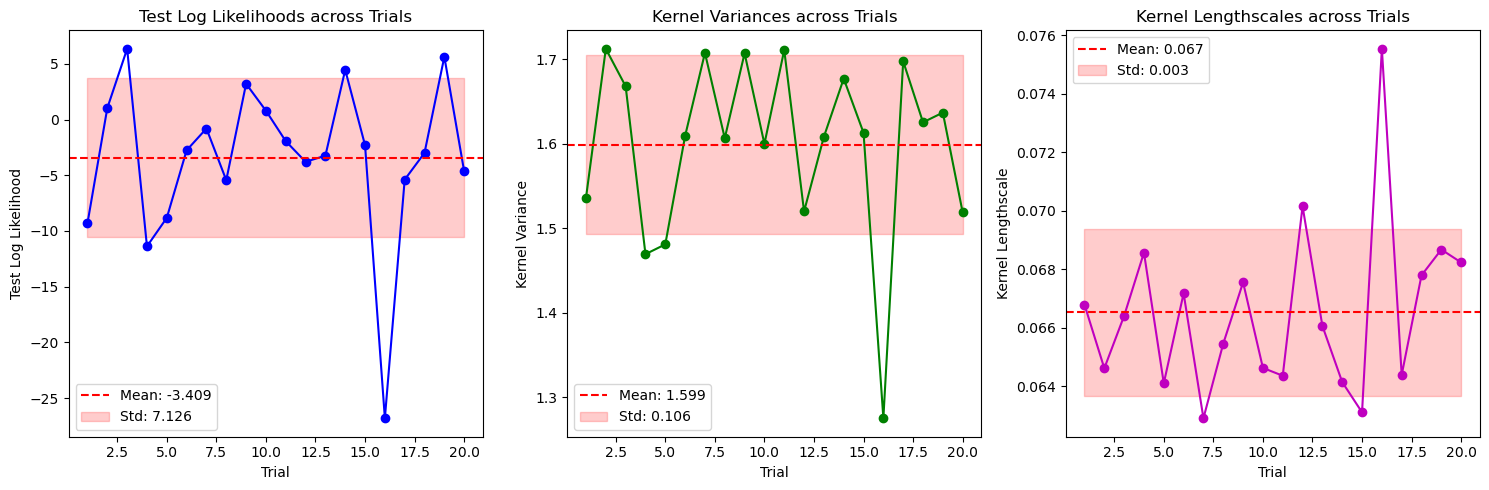

In [63]:
test_lls, variances, lengthscales = run_map_trials_with_vis(n_trials=20)

Step 200, Loss: 27.235
  Kernel Variance: 1.695
  Kernel Lengthscale: 0.061
Step 400, Loss: 27.235
  Kernel Variance: 1.711
  Kernel Lengthscale: 0.061
Step 600, Loss: 27.235
  Kernel Variance: 1.711
  Kernel Lengthscale: 0.061
Step 800, Loss: 27.235
  Kernel Variance: 1.711
  Kernel Lengthscale: 0.061
Step 1000, Loss: 27.235
  Kernel Variance: 1.711
  Kernel Lengthscale: 0.061
Step 200, Loss: 25.550
  Kernel Variance: 1.720
  Kernel Lengthscale: 0.064
Step 400, Loss: 25.549
  Kernel Variance: 1.742
  Kernel Lengthscale: 0.064
Step 600, Loss: 25.549
  Kernel Variance: 1.742
  Kernel Lengthscale: 0.064
Step 800, Loss: 25.549
  Kernel Variance: 1.742
  Kernel Lengthscale: 0.064
Step 1000, Loss: 25.549
  Kernel Variance: 1.742
  Kernel Lengthscale: 0.064
Step 200, Loss: 26.571
  Kernel Variance: 1.638
  Kernel Lengthscale: 0.065
Step 400, Loss: 26.571
  Kernel Variance: 1.644
  Kernel Lengthscale: 0.065
Step 600, Loss: 26.571
  Kernel Variance: 1.644
  Kernel Lengthscale: 0.065
Step 800, 

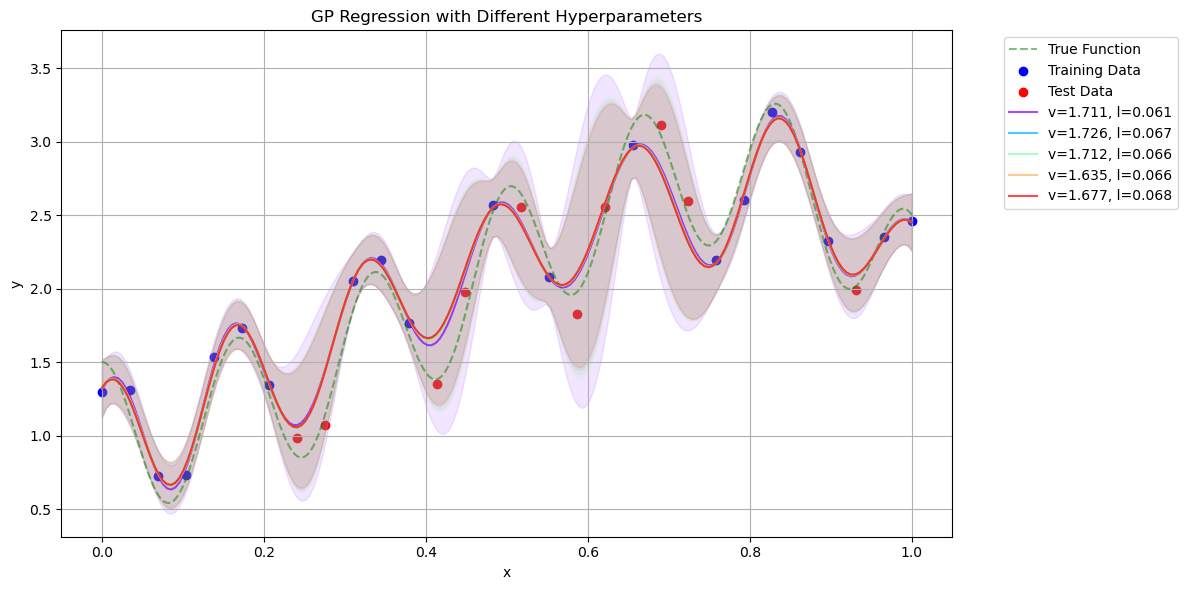

In [64]:
def plot_multiple_hyperparameter_fits(x_train, y_train, x_test, y_test, hyperparameters_list, num_to_plot=5):
    """
    Plot multiple GP fits using different hyperparameters on the same dataset.
    
    Args:
        x_train, y_train: Training data
        x_test, y_test: Test data
        hyperparameters_list: List of dictionaries containing 'kernel_variance' and 'kernel_lengthscale'
        num_to_plot: Number of different fits to show
    """
    plt.figure(figsize=(12, 6))
    
    # Plot true function
    x_true = torch.linspace(0, 1, 1000)
    y_true = -(torch.sin(6 * np.pi * x_true))**2 + 6 * x_true**2 - 5 * x_true**4 + 3/2
    plt.plot(x_true, y_true, 'g--', alpha=0.5, label='True Function')
    
    # Plot data points
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.scatter(x_test, y_test, c='red', label='Test Data')
    
    # Plot predictions for different hyperparameters
    x_pred = torch.linspace(0, 1, 200)
    colors = plt.cm.rainbow(np.linspace(0, 1, num_to_plot))
    
    # Select a subset of hyperparameters to plot
    indices = np.linspace(0, len(hyperparameters_list)-1, num_to_plot).astype(int)
    
    for idx, params in enumerate([hyperparameters_list[i] for i in indices]):
        gp = GP()
        with torch.no_grad():
            gp.kernel_variance.data = torch.tensor(params['kernel_variance'])
            gp.kernel_lengthscale.data = torch.tensor(params['kernel_lengthscale'])
            
        mean, var = gp.predict(x_train, y_train, x_pred)
        std = torch.sqrt(var)
        
        plt.plot(x_pred, mean.detach(), color=colors[idx], 
                label=f'v={params["kernel_variance"]:.3f}, l={params["kernel_lengthscale"]:.3f}',
                alpha=0.7)
        plt.fill_between(x_pred.numpy(),
                        (mean - 2 * std).detach().numpy(),
                        (mean + 2 * std).detach().numpy(),
                        color=colors[idx], alpha=0.1)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Regression with Different Hyperparameters')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# To use this function:
def collect_hyperparameters(n_trials=20):
    """Collect hyperparameters from multiple trials"""
    hyperparameters_list = []
    
    for trial in range(n_trials):
        # Generate new dataset and fit GP
        x, y = generate_data(n_points=30)
        indices = torch.randperm(len(x))
        train_indices = indices[:20]
        test_indices = indices[20:]
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        
        gp = GP()
        gp.fit_map(x_train, y_train)
        
        hyperparameters_list.append({
            'kernel_variance': gp.kernel_variance.item(),
            'kernel_lengthscale': gp.kernel_lengthscale.item()
        })
    
    return hyperparameters_list

# Example usage:
# First collect hyperparameters from multiple runs
hyperparameters = collect_hyperparameters(n_trials=20)

# Generate a single dataset to visualize different fits
x, y = generate_data(n_points=30)
indices = torch.randperm(len(x))
train_indices = indices[:20]
test_indices = indices[20:]
x_train, y_train = x[train_indices], y[train_indices]
x_test, y_test = x[test_indices], y[test_indices]

# Plot multiple fits using the collected hyperparameters
plot_multiple_hyperparameter_fits(x_train, y_train, x_test, y_test, hyperparameters, num_to_plot=5)

Step 200, Loss: 22.565
  Kernel Variance: 1.524
  Kernel Lengthscale: 0.069
Step 400, Loss: 22.565
  Kernel Variance: 1.524
  Kernel Lengthscale: 0.069
Step 600, Loss: 22.565
  Kernel Variance: 1.524
  Kernel Lengthscale: 0.069
Step 800, Loss: 22.565
  Kernel Variance: 1.524
  Kernel Lengthscale: 0.069
Step 1000, Loss: 22.565
  Kernel Variance: 1.524
  Kernel Lengthscale: 0.069
Step 200, Loss: 22.386
  Kernel Variance: 1.586
  Kernel Lengthscale: 0.067
Step 400, Loss: 22.386
  Kernel Variance: 1.588
  Kernel Lengthscale: 0.067
Step 600, Loss: 22.386
  Kernel Variance: 1.588
  Kernel Lengthscale: 0.067
Step 800, Loss: 22.386
  Kernel Variance: 1.588
  Kernel Lengthscale: 0.067
Step 1000, Loss: 22.386
  Kernel Variance: 1.588
  Kernel Lengthscale: 0.067
Step 200, Loss: 21.888
  Kernel Variance: 1.540
  Kernel Lengthscale: 0.067
Step 400, Loss: 21.888
  Kernel Variance: 1.540
  Kernel Lengthscale: 0.067
Step 600, Loss: 21.888
  Kernel Variance: 1.540
  Kernel Lengthscale: 0.067
Step 800, 

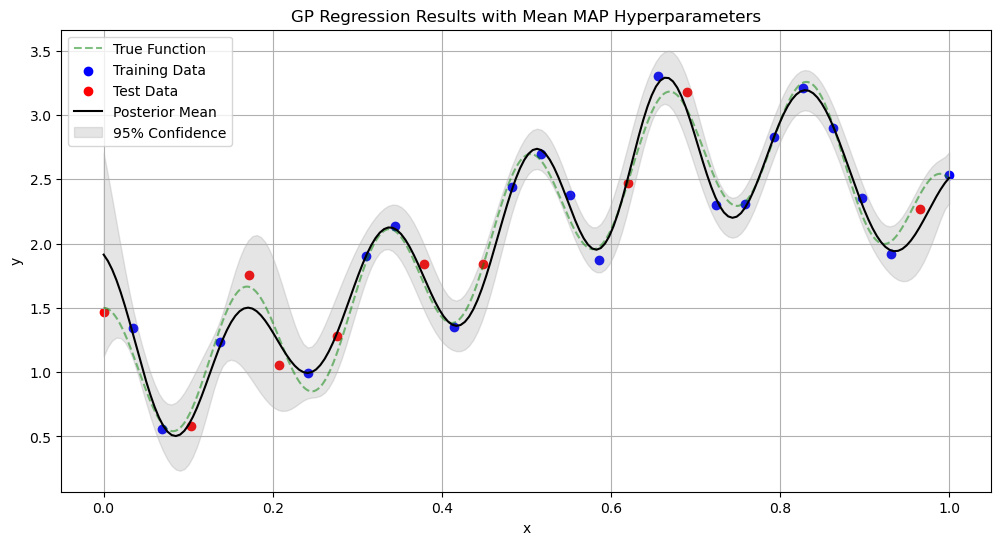

Test Log Likelihood: 4.516


In [66]:
def fit_with_mean_hyperparameters(n_trials=20):
    """
    Run multiple trials, compute mean hyperparameters, and fit a GP with those values
    """
    # First collect hyperparameters from multiple runs
    kernel_variances = []
    kernel_lengthscales = []
    
    for trial in range(n_trials):
        x, y = generate_data(n_points=30)
        indices = torch.randperm(len(x))
        train_indices = indices[:20]
        test_indices = indices[20:]
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_test, y_test = x[test_indices], y[test_indices]
        
        gp = GP()
        gp.fit_map(x_train, y_train)
        
        kernel_variances.append(gp.kernel_variance.item())
        kernel_lengthscales.append(gp.kernel_lengthscale.item())
    
    # Compute mean hyperparameters
    mean_variance = np.mean(kernel_variances)
    mean_lengthscale = np.mean(kernel_lengthscales)
    
    print(f"Mean Kernel Variance: {mean_variance:.3f}")
    print(f"Mean Kernel Lengthscale: {mean_lengthscale:.3f}")
    
    # Generate a new dataset for the final fit
    x, y = generate_data(n_points=30)
    indices = torch.randperm(len(x))
    train_indices = indices[:20]
    test_indices = indices[20:]
    
    x_train, y_train = x[train_indices], y[train_indices]
    x_test, y_test = x[test_indices], y[test_indices]
    
    # Create GP with mean hyperparameters
    gp = GP()
    with torch.no_grad():
        gp.kernel_variance.data = torch.tensor(mean_variance)
        gp.kernel_lengthscale.data = torch.tensor(mean_lengthscale)
    
    # Plot the results
    x_pred = torch.linspace(0, 1, 200)
    mean, var = gp.predict(x_train, y_train, x_pred)
    std = torch.sqrt(var)
    
    plt.figure(figsize=(12, 6))
    
    # Plot true function
    x_true = torch.linspace(0, 1, 1000)
    y_true = -(torch.sin(6 * np.pi * x_true))**2 + 6 * x_true**2 - 5 * x_true**4 + 3/2
    plt.plot(x_true, y_true, 'g--', alpha=0.5, label='True Function')
    
    # Plot data points
    plt.scatter(x_train, y_train, c='blue', label='Training Data')
    plt.scatter(x_test, y_test, c='red', label='Test Data')
    
    # Plot GP prediction
    plt.plot(x_pred, mean.detach(), 'k-', label='Posterior Mean')
    plt.fill_between(
        x_pred.numpy(),
        (mean - 2 * std).detach().numpy(),
        (mean + 2 * std).detach().numpy(),
        color='gray',
        alpha=0.2,
        label='95% Confidence'
    )
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('GP Regression Results with Mean MAP Hyperparameters')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute and return test log likelihood
    mean_test, var_test = gp.predict(x_train, y_train, x_test)
    std_test = torch.sqrt(var_test)
    test_ll = torch.distributions.Normal(mean_test, std_test).log_prob(y_test).sum().item()
    print(f"Test Log Likelihood: {test_ll:.3f}")
    
    return gp, test_ll

gp, test_ll = fit_with_mean_hyperparameters(n_trials=20)